### It did not solve the problem but it is a stepping stone to thw right direction, i try to implement it like the vartpole problem but it has issue of reward which is always 1

In [20]:
#!sudo apt-get install xvfb

#!pip install gym[classic_control]


#!pip install gym-notebook-wrapper


#!pip install pygame

In [21]:
#!pip install tensorboardX

In [22]:
import gnwrapper

In [23]:
# Importing all the neccessar libraries

import gym, gym.spaces
from collections import namedtuple
import numpy as np
from tensorboardX import SummaryWriter

import torch
import torch.nn as nn
import torch.optim as optim


In [24]:
HIDDEN_SIZE = 128
BATCH_SIZE = 16
PERCENTILE = 70

In [25]:
# creating the class NN

class DiscreteOneHotWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        assert isinstance(env.observation_space,      # This function checks if env.observation_space
                          gym.spaces.Discrete)         # is an instance of gym.spaces.Discrete
        shape = (env.observation_space.n, )           # Takes the number of observation space
        self.observation_space = gym.spaces.Box(      # Create new observation space from box.space
            0.0, 1.0, shape, dtype=np.float32)        # with 0.0 as the low value and 1.0 as high value
                                                      # with shape i.e the number of observation space = 16
    def observation(self, observation):
        res = np.copy(self.observation_space.low)     # this returns the low value of the observation space
                                                      #which is zero which number depends on the number of the 
                                                      #observation space. in this case 16 zeros
        res[observation] = 1.0    #This step is used to convert the observation into one-hot encoded array where 
                                #all the other elements are 0 and only the element that corresponds 
                                #to observation will be set to 1
        return res


class Net(nn.Module):
    def __init__(self, obs_size, hidden_size, n_actions):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions)
        )

    def forward(self, x):
        return self.net(x)


In [26]:
#creating a name tupple 
Episode = namedtuple('Episode', field_names=['reward', 'steps'])
EpisodeStep = namedtuple('EpisodeStep', field_names=['observation', 'action'])


In [27]:
def iterate_batches(env, net, batch_size):
    batch = []
    episode_reward = 0.0
    episode_steps = []
    obs = env.reset()            # reset the environment for new observations
    sm = nn.Softmax(dim=1)      # set up the optimizer 
    while True:
        obs_v = torch.FloatTensor([obs])     #convert the obs to tensor with gradient decent 
        act_probs_v = sm(net(obs_v))        #optimize the tensor 
        act_probs = act_probs_v.data.numpy()[0]  # converting the tensors to numpy array and taking the first index
        action = np.random.choice(len(act_probs), p=act_probs) #It can be viewed as a way of randomly selecting an action, 
                                                              #but with a bias towards the actions that have higher probabilities according to the agent's policy
        next_obs, reward, is_done, _ = env.step(action)   # We reset the environment again to get observation
        episode_reward += reward
        episode_steps.append(EpisodeStep(observation=obs, action=action))
        if is_done:
            batch.append(Episode(reward=episode_reward, steps=episode_steps))
            episode_reward = 0.0
            episode_steps = []
            next_obs = env.reset()
            if len(batch) == batch_size:
                yield batch
                batch = []
        obs = next_obs


In [28]:
def filter_batch(batch, percentile):
    rewards = list(map(lambda s: s.reward, batch))  # example rewards = [s.reward for s in batch]
    reward_bound = np.percentile(rewards, percentile)# setting a reward bound of 90 percentile and if any 
    reward_mean = float(np.mean(rewards))           # Taking the mean of all the reward

    train_obs = []
    train_act = []
    for example in batch:
        if example.reward < reward_bound:   # If reward is less than reward bound
            continue
        train_obs.extend(map(lambda step: step.observation, example.steps))  #This lambda function extract observation out from the 
                                                                          #Episode steps which have observation and action and was appended to Batch as 
                                                                          #as steps
        train_act.extend(map(lambda step: step.action, example.steps))   # This also extract action from episode steps that was appended to batch as steps

    train_obs_v = torch.FloatTensor(train_obs)       # Turn the the train observation to float tensor with gradient
    train_act_v = torch.LongTensor(train_act)        #Turn the train action to long tensor with gradient
    return train_obs_v, train_act_v, reward_bound, reward_mean  # return this

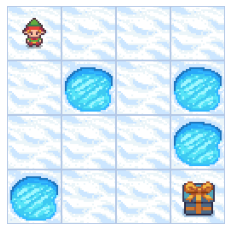

5952: loss=0.000, reward_mean=0.0, reward_bound=0.0


In [ ]:
if __name__ == "__main__":
    envm = gnwrapper.Animation(gym.make('FrozenLake-v1'))  # Wrapp the environment with gnwrapper for visualization
    env = DiscreteOneHotWrapper(envm)
    # env = gym.wrappers.Monitor(env, directory="mon", force=True)
    obs_size = env.observation_space.shape[0]  # This returns the amount or number of features observation space
    n_actions = env.action_space.n            # This line of code is extracting the number of possible 
                                                #actions in the action space of an environment.

    net = Net(obs_size, HIDDEN_SIZE, n_actions)
    objective = nn.CrossEntropyLoss()              
    optimizer = optim.Adam(params=net.parameters(), lr=0.01)
    writer = SummaryWriter(comment="-frozenlake-naive")

    for iter_no, batch in enumerate(iterate_batches(env, net, BATCH_SIZE)):
        obs_v, acts_v, reward_b, reward_m = filter_batch(batch, PERCENTILE)
        optimizer.zero_grad()
        action_scores_v = net(obs_v)
        loss_v = objective(action_scores_v, acts_v)
        loss_v.backward()
        optimizer.step()
        env.render()
        print("%d: loss=%.3f, reward_mean=%.1f, reward_bound=%.1f" % (
            iter_no, loss_v.item(), reward_m, reward_b))
        writer.add_scalar("loss", loss_v.item(), iter_no)
        writer.add_scalar("reward_bound", reward_b, iter_no)
        writer.add_scalar("reward_mean", reward_m, iter_no)
        if reward_m > 0.8:
            print("Solved!")
            break
    writer.close()
